In [193]:
import pandas as pd
import csv
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif
import seaborn as sns
import numpy as np
import datetime
# !pip install sweetviz

In [194]:
#read in the three dataset
accident_df = pd.read_csv('Road Safety Data - Accidents 2019.csv')
casualties_df = pd.read_csv('Road Safety Data - Casualties 2019.csv')
vehicles_df = pd.read_csv('Road Safety Data- Vehicles 2019.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data pre-processing and cleaning

In [306]:
accident_df["LSOA_of_Accident_Location"].replace(np.nan, "uknown", inplace=True)
accident_df.Time.fillna(accident_df.Time.mode()[0], inplace = True)
row_fills = accident_df.Latitude[accident_df.Latitude.isnull()].index.to_list()
for row in row_fills:
    key = accident_df.loc[row, 'Local_Authority_(District)']
    accident_df.loc[row, 'Longitude'] = np.mean(accident_df[accident_df['Local_Authority_(District)'] == key]['Longitude'])
    
for row in row_fills:
    key = accident_df.loc[row, 'Local_Authority_(District)']
    accident_df.loc[row, 'Latitude'] = np.mean(accident_df[accident_df['Local_Authority_(District)'] == key]['Latitude']) 

In [314]:
# adds decimal time, hour, day and minute to the df
def tdh(df):
    df['hour'] = df.Time.dt.hour
    df['minute'] = df.Time.dt.minute
    df['decimal_time'] = df.hour + df.minute/60
    df['day'] = df.Date.dt.day

# create a function to determine the hours of the day which accidents occur.
def timeperiod(hour):
    if hour in range(6, 10):
        return 'Morning Rush Hour(6-10)'
    elif hour in range(10, 15):
        return 'off peak period (10-15)'
    elif hour in range(15, 19):
        return 'Afternoon Rush Hour (15-19)'
    elif hour in range(19, 23):
         return 'End of Work (19-23)'
    else:
            return 'Late Night (23-6)'

# Create function to convert variables with object datatypes to string.      
def convert_to_string(df, col):
    df[col] = df[col].apply(str)
def tdh(df):
    df['hour'] = df.Time.dt.hour
    df['minute'] = df.Time.dt.minute
    df['decimal_time'] = df.hour + df.minute/60
    df['day'] = df.Date.dt.day

# create a function to determine the hours of the day which accidents occur.
def timeperiod(hour):
    if hour in range(6, 10):
        return 'Morning Rush Hour(6-10)'
    elif hour in range(10, 15):
        return 'off peak period (10-15)'
    elif hour in range(15, 19):
        return 'Afternoon Rush Hour (15-19)'
    elif hour in range(19, 23):
         return 'End of Work (19-23)'
    else:
            return 'Late Night (23-6)'

# Create function to convert variables with object datatypes to string.      
def convert_to_string(df, col):
    df[col] = df[col].apply(str)
    
    
def convert_date(col):
    accident_df[col] = pd.to_datetime(accident_df[col])

In [316]:
# changes all 
convert_to_string(accident_df, 'Accident_Index')
convert_to_string(vehicles_df, 'Accident_Index')
convert_to_string(casualties_df, 'Accident_Index')
convert_date('Time')
convert_date('Date')
tdh(accident_df)
accident_df['period'] = accident_df['hour'].apply(timeperiod)      
accident_df['Week_Day'] = accident_df['Day_of_Week'].map({1: 'Sunday', 2:'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'})

In [310]:
#convert time to decimal time
# accident_df['converted_time'] = pd.DatetimeIndex(accident_df['Time'])
# accident_df["decimal_time"] = accident_df['converted_time'].dt.hour + accident_df['converted_time'].dt.minute/60


### QUESTION A - ARE THERE SIGNIFICANT HOURS OF THE DAY, DAYS OF THE WEEK, ON WHICH ACCIDENTS OCCUR?

In [317]:
# ##Read in and load road safet data- Accidents  dataset for a preview of what the data looks like
# accident_df = pd.read_csv('Road Safety Data - Accidents 2019.csv')
# casualties_df = pd.read_csv('Road Safety Data - Casualties 2019.csv')
# vehicles_df = pd.read_csv('Road Safety Data- Vehicles 2019.csv')

accident_df

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,sunset,sunrise_decimal_time,sunset_decimal_time,Weather,Roads,Road_surface,sunrise_before,sunrise_after,sunset_before,sunset_after
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,...,2022-04-29 17:20:00,7.166667,17.333333,Fine no high winds,Roundabout,Data missing,False,False,False,False
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,...,2022-04-29 16:21:00,8.000000,16.350000,Fine no high winds,One way street,Data missing,False,False,False,False
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,...,2022-04-29 16:02:00,8.116667,16.033333,Fine no high winds,Single carriageway,Data missing,False,False,False,False
3,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,2019-01-01,...,2022-04-29 16:02:00,8.116667,16.033333,Fine no high winds,Single carriageway,Data missing,False,False,False,False
4,2019010155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,2019-01-01,...,2022-04-29 16:02:00,8.116667,16.033333,Fine no high winds,Single carriageway,Data missing,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117531,2019984106919,312635.0,573392.0,-3.368899,55.047323,98,3,1,1,2019-05-18,...,2022-04-29 21:19:00,5.016667,21.316667,Fine no high winds,Single carriageway,Wet or damp,False,False,False,False
117532,2019984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,2019-05-30,...,2022-04-29 21:38:00,4.700000,21.633333,Fine no high winds,Single carriageway,Wet or damp,False,False,False,False
117533,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,...,2022-04-29 21:56:00,4.566667,21.933333,Fine no high winds,Single carriageway,Data missing,False,False,False,False
117534,2019984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,1,2019-06-29,...,2022-04-29 21:55:00,4.583333,21.916667,Fine no high winds,Single carriageway,Data missing,False,False,False,False


In [318]:
accident_df['Week_Day'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [319]:
accident_df["Time"]

0        2022-04-29 17:50:00
1        2022-04-29 21:45:00
2        2022-04-29 01:50:00
3        2022-04-29 01:20:00
4        2022-04-29 00:40:00
                 ...        
117531   2022-04-29 01:00:00
117532   2022-04-29 08:46:00
117533   2022-04-29 15:30:00
117534   2022-04-29 14:10:00
117535   2022-04-29 12:45:00
Name: Time, Length: 117536, dtype: datetime64[ns]

In [320]:
accident_df["decimal_time"]

0         17.833333
1         21.750000
2          1.833333
3          1.333333
4          0.666667
            ...    
117531     1.000000
117532     8.766667
117533    15.500000
117534    14.166667
117535    12.750000
Name: decimal_time, Length: 117536, dtype: float64

In [321]:
accident_df["converted_time"]

0        2022-04-29 17:50:00
1        2022-04-29 21:45:00
2        2022-04-29 01:50:00
3        2022-04-29 01:20:00
4        2022-04-29 00:40:00
                 ...        
117531   2022-04-29 01:00:00
117532   2022-04-29 08:46:00
117533   2022-04-29 15:30:00
117534   2022-04-29 14:10:00
117535   2022-04-29 12:45:00
Name: converted_time, Length: 117536, dtype: datetime64[ns]

##### HOUR OF THE DAY

<Figure size 720x864 with 0 Axes>

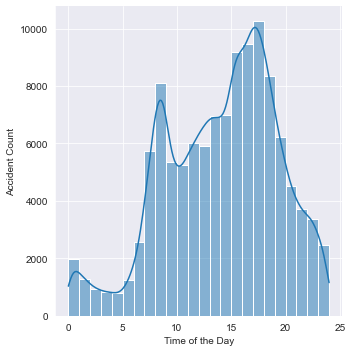

In [322]:
### Hour of the day 
%matplotlib inline
sns.set_style('darkgrid')
plt.figure(figsize = (10,12))
sns.displot(data=accident_df,x=accident_df["decimal_time"],kde=True, bins = 24)
plt.xlabel("Time of the Day")
plt.ylabel("Accident Count")
plt.show()


Text(0, 0.5, 'Accident Count')

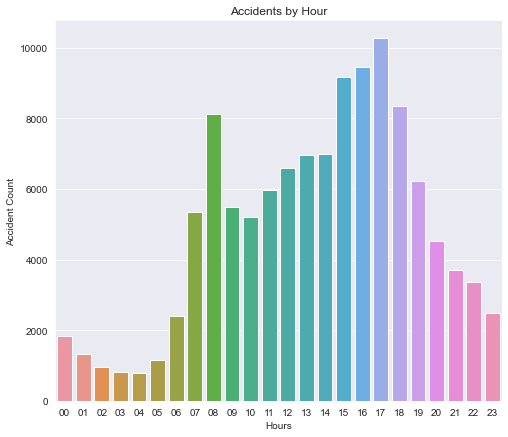

In [323]:
#Accident by specific hour of the day
hours = pd.DataFrame(accident_df["Time"].astype("datetime64"))
hours = pd.DataFrame(hours.Time.dt.strftime('%H').sort_values(),columns=["Time"])
plt.figure(figsize=(8,7))
sns.countplot(data=hours,x="Time")
plt.title("Accidents by Hour")
plt.xlabel("Hours")
plt.ylabel("Accident Count")

###### Day of the week

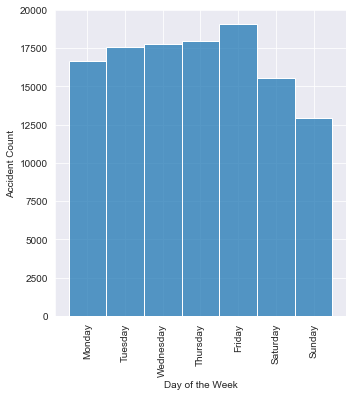

6    19056
5    17973
4    17775
3    17598
2    16643
7    15556
1    12935
Name: Day_of_Week, dtype: int64

In [324]:
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=accident_df,x=accident_df["Week_Day"], bins = 7)
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.xticks(rotation=90)
plt.show()
days = accident_df['Day_of_Week'].value_counts()
days



### QUESTION B - FOR MOTORBIKES, ARE THERE SIGNIFICANT HOURS OF THE DAY, AND DAYS OF THE WEEK ON WHICH ACCIDENTS OCCUR?

In [326]:
#vehicle dataframe overview
vehicles_df

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Age_band,journey_purpose
0,2019010128300,1,9,0,-1,-1,-1,-1,-1,-1,...,58,9,-1,-1,-1,2,1,2,56-65,Not known
1,2019010128300,2,9,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,2,1,2,Out of range,Not known
2,2019010152270,1,9,0,18,-1,0,-1,-1,-1,...,24,5,-1,-1,-1,3,1,3,21-25,Not known
3,2019010152270,2,9,0,18,-1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,6,1,6,Out of range,Not known
4,2019010155191,1,9,0,3,0,1,0,0,0,...,45,7,-1,-1,-1,4,1,4,36-45,Not known
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216376,2019984107019,4,19,0,18,0,0,0,0,0,...,20,4,2198,2,4,5,3,5,16-20,Journey part of work
216377,2019984107219,1,9,0,18,0,1,0,0,0,...,33,6,1997,2,12,3,2,3,26-35,Not known
216378,2019984107219,2,9,0,18,0,1,0,0,0,...,61,9,2967,2,5,7,3,7,56-65,Not known
216379,2019984107419,1,9,0,7,0,6,0,0,3,...,78,11,1597,2,6,8,3,8,Over 75,Other


#### Motorbike accident by hour of the day

In [327]:
#Filter through the vehicle types for vehicles that classify as motorbikes
motor_bike1=vehicles_df[(vehicles_df["Vehicle_Type"]==2)]
motor_bike2=vehicles_df[(vehicles_df["Vehicle_Type"]==3)]
motor_bike3=vehicles_df[(vehicles_df["Vehicle_Type"]==4)]
motor_bike4=vehicles_df[(vehicles_df["Vehicle_Type"]==5)]
motor_bike5=vehicles_df[(vehicles_df["Vehicle_Type"]==23)]
motor_bike6=vehicles_df[(vehicles_df["Vehicle_Type"]==97)]
#total motorbikes
motor_bikes = pd.concat([motor_bike1,motor_bike2,motor_bike3,motor_bike4,motor_bike5,motor_bike6], ignore_index= True)

#merge the accident_df with motor_bikes to get a new dataframe
motor_bikes_df = accident_df.merge(motor_bikes, on=['Accident_Index'], how='inner')

#All motorbike dataframe
motor_bikes
motor_bikes_df
motor_bikes_df['Week_Day'] = motor_bikes_df['Day_of_Week'].map({1: 'Sunday', 2:'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'})

###### Motorbike accident by hour of the day

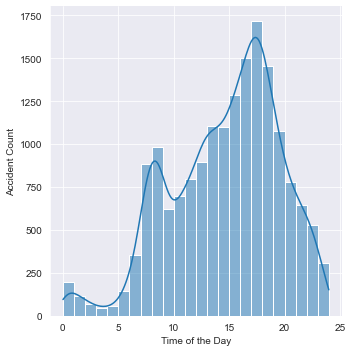

In [328]:
#histogram showing accidents for motorbikes by hour of the day
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=motor_bikes_df,x="decimal_time",kde=True, bins = 24)
plt.xlabel("Time of the Day")
plt.ylabel("Accident Count")
plt.show()

##### Motorbike accident by specific hour of the day

Text(0, 0.5, 'Accident Count')

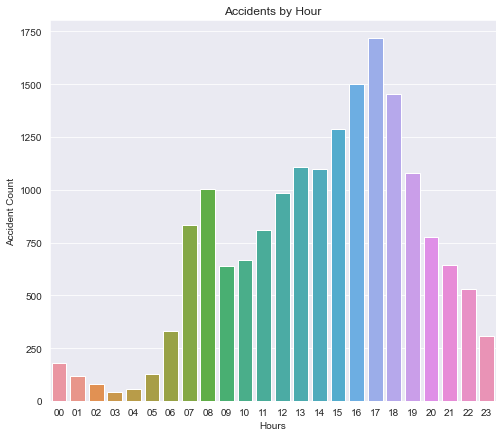

In [329]:
#Motorbike accident by specific hour of the day
hours = pd.DataFrame(motor_bikes_df["Time"].astype("datetime64"))
hours = pd.DataFrame(hours.Time.dt.strftime('%H').sort_values(),columns=["Time"])
plt.figure(figsize=(8,7))
sns.countplot(data=hours,x="Time")
plt.title("Accidents by Hour")
plt.xlabel("Hours")
plt.ylabel("Accident Count")

#### Motorbike accident by days of the week

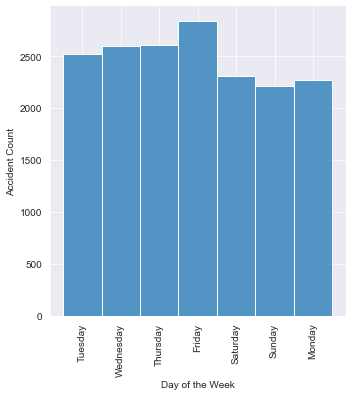

In [330]:
#Accident for motorbikes for days of the week
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=motor_bikes_df,x="Week_Day", bins = 7)
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.xticks(rotation=90)
plt.show()

In [331]:
# total_days = motor_bikes_df['Day_of_Week'].sum()
# sun_freq = (motor_bikes_df['Day_of_Week'] == 1).sum()
# mon_freq = (motor_bikes_df['Day_of_Week'] == 2).sum()
# tue_freq = (motor_bikes_df['Day_of_Week'] == 3).sum()
# wed_freq = (motor_bikes_df['Day_of_Week'] == 4).sum()
# thur_freq = (motor_bikes_df['Day_of_Week'] == 5).sum()
# fri_freq = (motor_bikes_df['Day_of_Week'] == 6).sum()
# sat_freq = (motor_bikes_df['Day_of_Week'] == 7).sum()

### QUESTION C - FOR PEDESTRIANS INVOLVED IN ACCIDENTS, ARE THERE SIGNIFICANT HOURS OF THE DAY AND DAYS OF THE WEEK ON WHICH THEY ARE MORE LIKELY TO BE INVOLVED? 

In [332]:
#casualties dataframe overview
casualties_df

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2019010128300,1,1,1,1,58,9,3,0,0,0,0,0,9,1,2
1,2019010128300,1,2,2,2,-1,-1,3,0,0,1,0,0,9,1,5
2,2019010128300,1,3,2,2,-1,-1,3,0,0,2,0,0,9,1,5
3,2019010152270,1,1,1,2,24,5,3,0,0,0,0,0,9,1,3
4,2019010155191,2,1,2,2,21,5,3,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153153,2019984106919,1,1,1,1,24,5,3,0,0,0,0,0,19,3,6
153154,2019984107019,1,1,1,1,22,5,3,0,0,0,0,0,19,1,1
153155,2019984107219,2,1,1,1,61,9,3,0,0,0,0,0,9,3,7
153156,2019984107419,1,1,3,1,54,8,3,5,3,0,0,0,0,3,8


In [333]:
#Pedestrian key from the variable lookup is 0
#create a df of pedestrians invloved in accidents
pedestrian_df = casualties_df[(casualties_df['Casualty_Type'] == 0)]
pedestrian_df


,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
5,2019010155192,1,1,3,1,68,10,2,5,4,0,0,0,0,1,4
11,2019010155196,1,1,3,1,40,7,3,1,3,0,0,0,0,1,4
19,2019010155209,1,1,3,1,23,5,3,1,1,0,0,0,0,1,8
20,2019010155210,1,1,3,1,24,5,1,5,1,0,0,0,0,1,10
21,2019010155216,1,1,3,1,38,7,3,5,3,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153108,2019983114119,1,1,3,1,64,9,2,5,1,0,0,0,0,1,4
153113,2019983115619,1,1,3,1,0,1,3,9,8,0,0,0,0,-1,-1
153131,2019984104219,1,1,3,2,75,10,2,6,9,0,0,0,0,2,4
153132,2019984104419,1,1,3,1,16,4,3,6,9,0,0,0,0,2,6


In [334]:
#merge the accident_df with pedestrian df to get a new dataframe
casualties_pedestrian_df = accident_df.merge(pedestrian_df, on=['Accident_Index'], how='inner')
casualties_pedestrian_df
casualties_pedestrian_df['Week_Day'] = casualties_pedestrian_df['Day_of_Week'].map({1: 'Sunday', 2:'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'})

##### Pedestrian accident by hours of the day

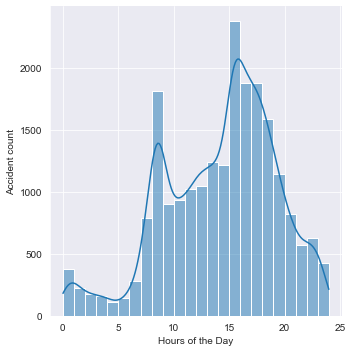

In [335]:
#pedestrian
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=casualties_pedestrian_df, x= 'decimal_time', kde = True, bins =24)
plt.xlabel("Hours of the Day")
plt.ylabel("Accident count")
plt.show()

##### Pedestrian accident by days of the week

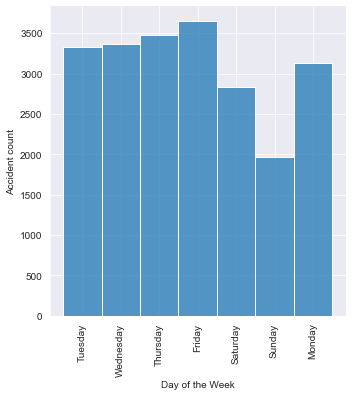

In [336]:
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=casualties_pedestrian_df, x= 'Week_Day', bins= 7)
plt.xlabel("Day of the Week")
plt.ylabel("Accident count")
plt.xticks(rotation=90)
plt.show()

### QUESTION D - WHAT IMPACT IF ANY, DOES DAYLIGHT SAVINGS HAVE ON ROAD TRAFFIC ACCIDENTS IN THE WEEK AFTER IT STARTS AND STOPS?

##### Daylight saving time 2019 in United Kingdom began at 01:00 on Sunday, 31 March and ended at 02:00 on Sunday, 27 October All times are in United Kingdom Time.

###### The typical implementation of Daylight saving time  is to set clocks forward by one hour in the spring ("spring forward"), and to set clocks back by one hour in autumn ("fall back") to return to standard time. As a result, there is one 23-hour day in late winter or early spring and one 25-hour day in autumn

In [337]:
accident_df['Day']=pd.DatetimeIndex(accident_df['Date']).day
accident_df['Month'] = pd.DatetimeIndex(accident_df['Date']).month
accident_df['Year'] = pd.DatetimeIndex(accident_df['Date']).year
accident_df['Date'] = pd.to_datetime(accident_df['Date'])
accident_df['Date']

0        2019-02-18
1        2019-01-15
2        2019-01-01
3        2019-01-01
4        2019-01-01
            ...    
117531   2019-05-18
117532   2019-05-30
117533   2019-06-21
117534   2019-06-29
117535   2019-04-21
Name: Date, Length: 117536, dtype: datetime64[ns]

In [338]:
#Get when daylight start and add a week to it 
#Get dayligh saving stop period and add a weeks to it to observe changes to accident figures
dls_start_interval = datetime.datetime(2019,3,31) + datetime.timedelta(weeks=1)
dls_stop_interval = datetime.datetime(2019,10,27) + datetime.timedelta(weeks=1)
print(dls_start_interval, dls_stop_interval)

2019-04-07 00:00:00 2019-11-03 00:00:00


In [339]:
#The week after DLS starts and the week after it stops
dls_start_week = accident_df[(accident_df['Date'] >= '2019-03-31') & (accident_df['Date'] <= '2019-04-07')]
dls_stop_week = accident_df[(accident_df['Date'] >= '2019-10-27') & (accident_df['Date'] <= '2019-11-03')]

In [435]:
week_after_start = (dls_start_week['Accident_Index'].count())
week_after_stop = dls_stop_week['Accident_Index'].count()

In [448]:
#Percentage of the general accident 
difference_after = week_after_stop-week_after_start
difference_after

56

In [449]:
(difference_after/week_after_start)*100

2.2399999999999998

### QUESTION E - WHAT IMPACT, IF ANY, DOES SUNRISE AND SUNSET TIMES HAVE ON ROAD TRAFFIC ACCIDENTS?

In [348]:
from suntime import Sun, SunTimeException
def sun_def(latitude, longitude, date):
    sun = Sun(latitude, longitude)
    date = date
    sunset = sun.get_local_sunset_time(date).strftime('%H:%M')
    sunrise = sun.get_local_sunrise_time(date).strftime('%H:%M')
    return sunrise, sunset

In [349]:
accident_df['sunrise'] = accident_df.apply(lambda x: sunrise_sunset(x['Latitude'], x['Longitude'], x['Date'])[0],axis=1)
accident_df['sunset'] = accident_df.apply(lambda x: sunrise_sunset(x['Latitude'], x['Longitude'], x['Date'])[1],axis=1)

In [350]:
convert_date('sunrise')
convert_date('sunset')

In [353]:
def tdh_sun(df, col, col_name):
    df[col_name] = df[col].dt.hour + df[col].dt.minute/60
    
tdh_sun(accident_df, 'sunrise', 'sunrise_decimal_time')
tdh_sun(accident_df, 'sunset', 'sunset_decimal_time')

In [362]:
#30 minutes to hour
time_place = 30/60
time_place

0.5

##### Sunrise

In [363]:
accident_df['prev_sunrise'] = accident_df.decimal_time.between((accident_df['sunrise_decimal_time']-time_place), accident_df['sunrise_decimal_time'])
accident_df['post_sunrise'] = accident_df.decimal_time.between(accident_df['sunrise_decimal_time'],(accident_df['sunrise_decimal_time'] + time_place))

In [366]:
# accident cout after sunrise 30 minutes before
prev_sunrise_df = accident_df[accident_df.prev_sunrise == True]
prev_sunrise_df = prev_sunrise_df.groupby('Day_of_Week')['Accident_Index'].count()
prev_sunrise_df

Day_of_Week
1    102
2    299
3    255
4    286
5    286
6    235
7    113
Name: Accident_Index, dtype: int64

In [367]:
# accident count after sunrise 30 minutes after
post_sunrise_df = accident_df[accident_df.post_sunrise == True]
post_sunrise_df = post_sunrise_df.groupby('Day_of_Week')['Accident_Index'].count()
post_sunrise_df

Day_of_Week
1    101
2    311
3    403
4    346
5    333
6    291
7    117
Name: Accident_Index, dtype: int64

In [370]:
# measure the significance of pre and post sunrise and see if we accept or reject null hypothesis
from scipy.stats import ttest_ind
# compare samples
stat, p = ttest_ind(prev_sunrise_df, post_sunrise_df)

print(stat, p)

# interpret
z = 0.05
if p > z:
  print('fail to reject H0')
else:
  print('reject H0')

-0.860244155787569 0.40651342135520974
fail to reject H0


#### Sunset

In [373]:
# Sunset
accident_df['pre_sunset'] = accident_df.decimal_time.between((accident_df['sunset_decimal_time']-time_place), accident_df['sunset_decimal_time'])
accident_df['post_sunset'] = accident_df.decimal_time.between(accident_df['sunset_decimal_time'],(accident_df['sunset_decimal_time'] + time_place))

In [374]:
# number of accidents 20 mins to sunset time
pre_sunset_df = accident_df[accident_df.pre_sunset == True]
pre_sunset_df = pre_sunset_df.groupby('Day_of_Week')['Accident_Index'].count()
pre_sunset_df

Day_of_Week
1    322
2    472
3    502
4    534
5    565
6    540
7    373
Name: Accident_Index, dtype: int64

In [375]:
# number of accidents 20 mins past sunset time
post_sunset_df = accident_df[accident_df.post_sunset == True]
post_sunset_df = post_sunset_df.groupby('Day_of_Week')['Accident_Index'].count()
post_sunset_df

Day_of_Week
1    318
2    461
3    491
4    540
5    548
6    520
7    367
Name: Accident_Index, dtype: int64

In [376]:
# student's t-test
from scipy.stats import ttest_ind
# compare samples
stat, p = ttest_ind(pre_sunset_df, post_sunset_df)

print(stat, p)

# interpret
z = 0.05
if p > z:
  print('fail to reject H0')
else:
  print('reject H0')

0.18656016924493035 0.8551222827087347
fail to reject H0


### QUESTION F - ARE THERE PARTICULAR TYPES OF VEHICLE (ENGINE CAPACITY AND AGE ) THAT ARE MORE FREQUENTLY INVOLVED IN ROAD TRAFFIC ACCIDENT?

##### Vehicle cc and age

In [377]:
#A look at the engine capapcity and unique age of vehicles in the dataframe
vehicles_df['Engine_Capacity_(CC)']
vehicles_df['Age_of_Vehicle'].unique()

array([-1,  4,  1, 14,  7, 12, 15, 11,  5,  2, 10, 17,  8, 22,  9,  6, 18,
        3, 16, 27, 13, 20, 21, 19, 23, 26, 24, 38, 53, 30, 25, 29, 37, 28,
       33, 39, 31, 36, 44, 40, 35, 57, 34, 41, 59, 32, 42, 45, 87, 94, 63,
       52, 48, 90, 54, 47, 60, 55, 66, 43, 58, 50, 46, 88, 72, 51, 74, 65,
       56, 77, 62, 61, 71, 49, 80])

In [378]:

vehicle_eng_age = vehicles_df.loc[:, vehicles_df.columns.intersection(['Engine_Capacity_(CC)','Age_of_Vehicle'])]
vehicle_eng_age

,Engine_Capacity_(CC),Age_of_Vehicle
0,-1,-1
1,-1,-1
2,-1,-1
3,-1,-1
4,-1,-1
...,...,...
216376,2198,4
216377,1997,12
216378,2967,5
216379,1597,6


In [379]:
kmeans=KMeans(n_clusters=10)
kmeans.fit(vehicle_eng_age)

KMeans(n_clusters=10)

In [380]:
labels=kmeans.predict(vehicle_eng_age)
centroids = kmeans.cluster_centers_
centroids


array([[ 2.03604736e+03,  7.89483184e+00],
       [ 9.89403585e+03,  6.71239283e+00],
       [ 1.80805227e+01, -2.63211239e-02],
       [ 6.87238316e+03,  7.47573898e+00],
       [ 1.29349341e+03,  8.71848014e+00],
       [ 2.89476089e+03,  9.12562455e+00],
       [ 4.54363160e+03,  6.54673445e+00],
       [ 1.28049140e+04,  4.77133956e+00],
       [ 9.29376139e+02,  7.37381245e+00],
       [ 1.60769625e+03,  7.64206148e+00]])

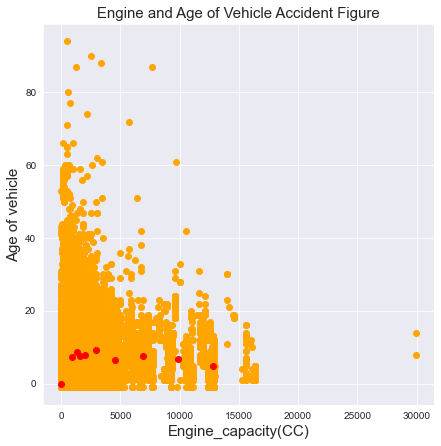

In [381]:
fig = plt.figure(figsize=(7,7))
colors = map(lambda x: colmap[x+1], labels)
plt.xlabel('Engine_capacity(CC)',fontdict = {'fontsize' : 15})
plt.ylabel('Age of vehicle',fontdict = {'fontsize' : 15})
plt.title('Engine and Age of Vehicle Accident Figure', fontdict = {'fontsize' : 15})
plt.scatter(vehicle_eng_age['Engine_Capacity_(CC)'],vehicle_eng_age['Age_of_Vehicle'],color="orange")
plt.scatter(centroids[:,0],centroids[:,1],color="red")
plt.show()

### QUESTION G - ARE THERE PARTICULAR CONDITIONS (WEATHER, GEOGRAPHIC LOCATION, SITUATIONS) THAT GENERATE MORE ROAD TRAFFIC ACCIDENTS?

##### Weather condtions

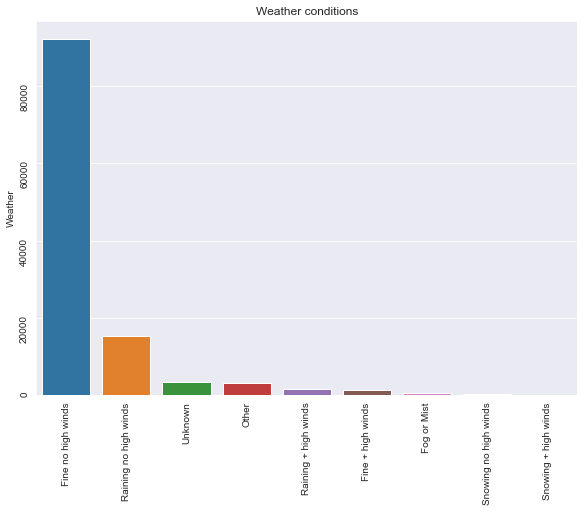

Fine no high winds       92316
Raining no high winds    15294
Unknown                   3436
Other                     3043
Raining + high winds      1430
Fine + high winds         1230
Fog or Mist                394
Snowing no high winds      353
Snowing + high winds        40
Name: Weather, dtype: int64

In [382]:
accident_df['Weather_Conditions'].unique()

accident_df['Weather'] = accident_df['Weather_Conditions'].map({1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or Mist', 8: 'Other', 9: 'Unknown'})
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
weather = accident_df["Weather"].value_counts()
sns.barplot(ax=axs, x = weather.index, y = weather)
axs.set_title("Weather conditions")
axs.tick_params(labelrotation=90)
plt.show()
weather


In [450]:
(92316/accident_df['Accident_Index'].count())*100

78.54274435066702

In [451]:
(15294/accident_df['Accident_Index'].count())*100

13.012183501225156

##### Road type

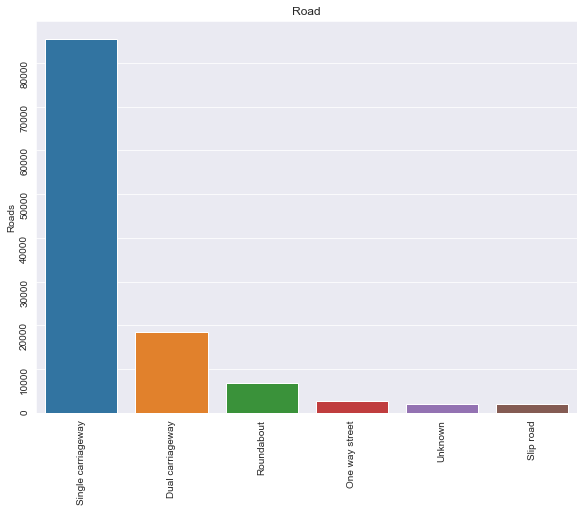

Single carriageway    85320
Dual carriageway      18590
Roundabout             6880
One way street         2664
Unknown                2143
Slip road              1939
Name: Roads, dtype: int64

In [383]:
accident_df['Roads'] = accident_df['Road_Type'].map({1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 9: 'Unknown'})
roads = accident_df['Roads'].value_counts()
# Road type
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
sns.barplot(ax=axs, x = roads.index, y = roads)
axs.set_title("Road")
axs.tick_params(labelrotation=90)
plt.show()
roads

In [452]:
(85320/accident_df['Accident_Index'].count())*100

72.59052545603049

###### Speed limit

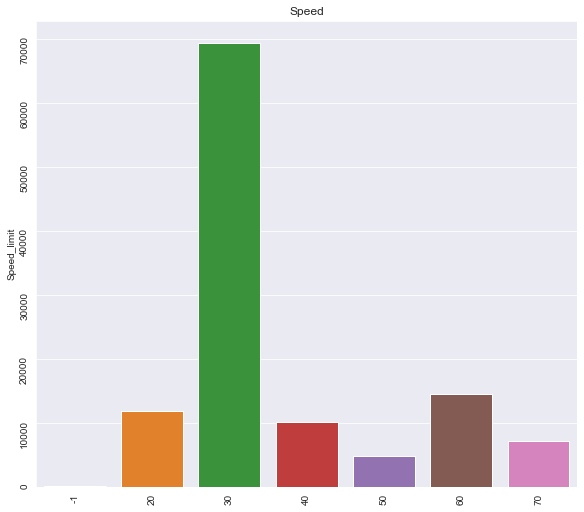

 30    69305
 60    14514
 20    11747
 40    10021
 70     7153
 50     4716
-1        80
Name: Speed_limit, dtype: int64

In [384]:
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
speed = accident_df['Speed_limit'].value_counts()
sns.barplot(ax=axs, x = speed.index, y = speed)
axs.set_title("Speed")
axs.tick_params(labelrotation=90)
plt.show()
speed

###### Road surface 

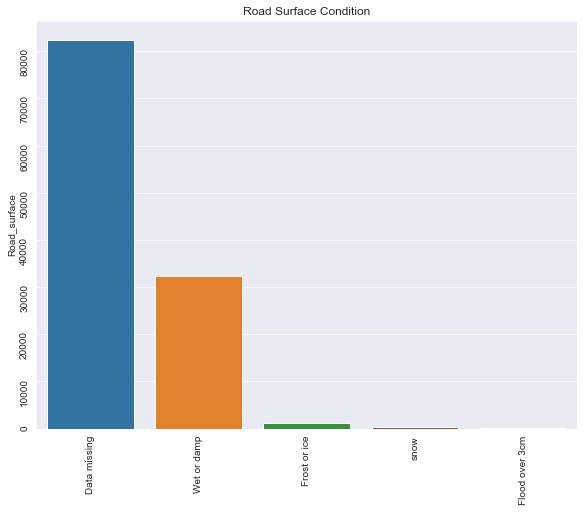

Data missing      82321
Wet or damp       32259
Frost or ice       1185
snow                245
Flood over 3cm      177
Name: Road_surface, dtype: int64

In [385]:
accident_df['Road_surface'] = accident_df['Road_Surface_Conditions'].map({1: 'Dry', 2: 'Wet or damp', 3: 'snow', 4: 'Frost or ice', 5: 'Flood over 3cm', 6: 'Oil and diesel', 7: 'Mud', 1: 'Data missing'})

fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
road_surface = accident_df['Road_surface'].value_counts()
sns.barplot(ax=axs, x = road_surface.index, y = road_surface)
axs.set_title("Road Surface Condition")
axs.tick_params(labelrotation = 90)
plt.show()
road_surface


#### Geographical Location

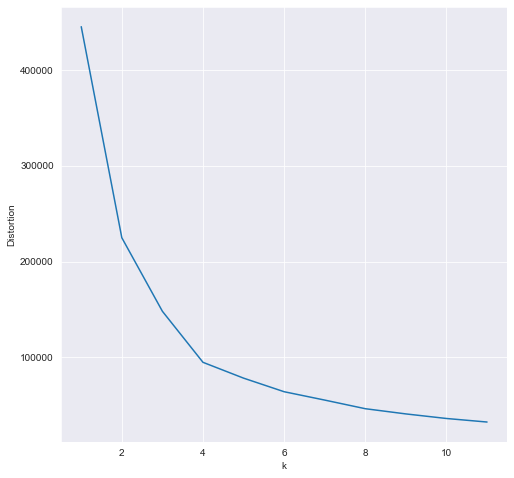

In [386]:
from sklearn.cluster import*

# use longitude and latitude to check location that are more frequently involve in road traffic accidents.
attributes = ['Longitude', 'Latitude']
geo = accident_df[attributes]

# Kmeans to form cluster
clusters = range(1, 12)
xy= list()

for i in clusters:
    km = KMeans(n_clusters=i, random_state= 42)
    km.fit(geo)
    x = km.inertia_
    xy.append(x)
    
plt.figure(figsize=(8,8))
plt.xlabel('k')
plt.ylabel('Distortion')
plt.plot(clusters, xy)

In [387]:
km = KMeans(n_clusters=4)
km.fit(geo)
labels = km.fit_predict(geo)
centroids = km.cluster_centers_

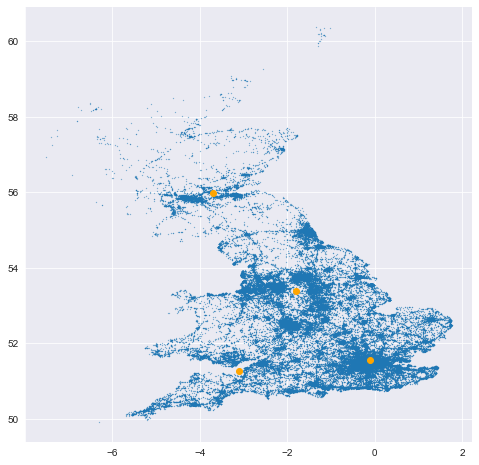

In [388]:
fig = plt.figure(figsize=(8,8))
plt.scatter(geo['Longitude'], geo['Latitude'], s=0.05)

plt.scatter(centroids[:,0], centroids[:,1], color='orange')
sns.despine()

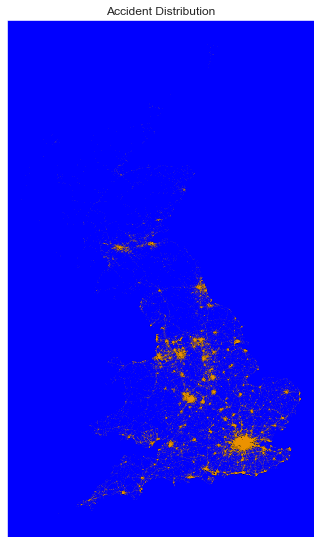

In [391]:
plt.figure(figsize=(5.5,9.5))
plt.axes().set_facecolor("blue")
plt.scatter(x = accident_df["Longitude"], y = accident_df["Latitude"],s=0.005, alpha= 0.25, color="orange")
plt.title("Accident Distribution")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

### QUESTION H - HOW DOES DRIVER RELATED VARIABLES AFFECT THE OUTCOME (E.G AGE OF THE DRIVER  AND THE PURPOSE OF THE JOURNEY )?

##### Age band of the driver

In [1]:
#Unique age band of drivers involved in accident
vehicles_df['Age_Band_of_Driver'].unique()

NameError: name 'vehicles_df' is not defined

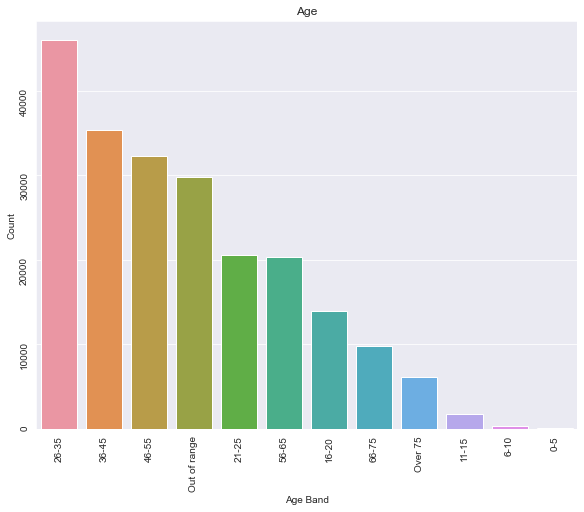

26-35           45993
36-45           35341
46-55           32281
Out of range    29756
21-25           20568
56-65           20344
16-20           13947
66-75            9848
Over 75          6169
11-15            1727
6-10              364
0-5                43
Name: Age_band, dtype: int64

In [393]:
# an histogram ranking the frequency of accidents according to the age band of the driver
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
vehicles_df['Age_band'] = vehicles_df['Age_Band_of_Driver'].map({1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75', -1: 'Out of range'}) 
age = vehicles_df['Age_band'].value_counts()
sns.barplot(ax=axs, x = age.index, y = age)
axs.set_title("Age")
axs.tick_params(labelrotation=90)
plt.ylabel('Count')
plt.xlabel('Age Band')
plt.show()
age

#### Journey purpose

In [2]:
vehicles_df['journey_purpose'] = vehicles_df['Journey_Purpose_of_Driver'].map({1: 'Journey part of work', 2: 'commuting to/from work', 3: 'Taking pupil to/from school', 4: 'Pupil riding to/from school', 5: 'Other', 6:'Not known', 15:'Other/Not known', -1: 'Data missing '})
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
journey_purpose = vehicles_df['journey_purpose'].value_counts()
sns.barplot(ax=axs, x = journey_purpose.index, y = journey_purpose)
axs.set_title("journey_purpose")
axs.tick_params(labelrotation=90)
plt.show()
journey_purpose

NameError: name 'vehicles_df' is not defined

In [395]:
factors = ['Journey_Purpose_of_Driver','Age_of_Driver','Sex_of_Driver','Driver_Home_Area_Type','Age_of_Vehicle']
accident_vehicles_df=accident_df.merge(vehicles_df, on=['Accident_Index'], how='inner')
factors_coded= accident_vehicles_df.dropna()
factors_coded.reset_index(drop=True)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Age_band,journey_purpose
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,...,58,9,-1,-1,-1,2,1,2,56-65,Not known
1,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,...,-1,-1,-1,-1,-1,2,1,2,Out of range,Not known
2,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,...,24,5,-1,-1,-1,3,1,3,21-25,Not known
3,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,...,-1,-1,-1,-1,-1,6,1,6,Out of range,Not known
4,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,...,45,7,-1,-1,-1,4,1,4,36-45,Not known
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214043,2019984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,1,2019-05-30,...,20,4,2198,2,4,5,3,5,16-20,Journey part of work
214044,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,...,33,6,1997,2,12,3,2,3,26-35,Not known
214045,2019984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,1,2019-06-21,...,61,9,2967,2,5,7,3,7,56-65,Not known
214046,2019984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,1,2019-06-29,...,78,11,1597,2,6,8,3,8,Over 75,Other


In [396]:
select_feature = factors_coded.filter( ['Age_of_Driver','Journey_Purpose_of_Driver','Accident_Severity','Sex_of_Driver','Age_of_Vehicle','Driver_Home_Area_Type'], axis=1)
conditional_feature = select_feature[(select_feature['Age_of_Driver'] > 0) & (select_feature['Journey_Purpose_of_Driver'] > 0) & (select_feature['Sex_of_Driver'] > 0) & (select_feature['Age_of_Vehicle'] > 0)& (select_feature['Driver_Home_Area_Type'] > 0)]


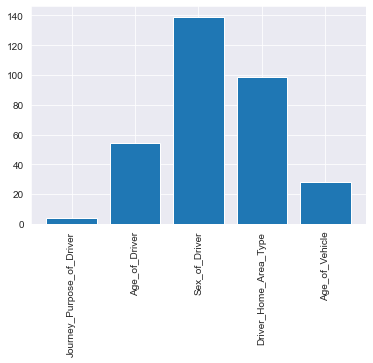

In [397]:
# Perform the feature selection
selector = SelectKBest(f_classif, k="all")
selector.fit(conditional_feature[factors], conditional_feature["Accident_Severity"])
scores = -np.log10(selector.pvalues_)
# plot the score using pyplot 
plt.bar(range(len(factors)), scores)
plt.xticks(range(len(factors)), factors, rotation='vertical')
plt.show()

### QUESTION I - CAN WE MAKE PREDICITIONS ABOUT WHEN AND WHERE ACCIDENTS WILL OCCUR, AND THE SEVERITY OF THE INJURIES SUSTAINED FROM THE DATA SUPPLIED TO IMPROVE ROAD SAFETY? HOW WELL DO OUR MODELS COMPARE TO GOVERNMENT MODELS?

In [461]:
# Decision Tree Classifier
from sklearn.model_selection import train_test_split
y_target = conditional_feature["Accident_Severity"].values
Xfeatures = conditional_feature.drop("Accident_Severity", axis=1)
X_train, X_validation, y_train, y_validation = train_test_split(Xfeatures,y_target,test_size=.25,random_state=1)

In [462]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(criterion="gini") 
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_validation)
sk_report = classification_report(digits=6,y_true=y_validation,y_pred=Y_pred)

In [463]:
accuracy = round(decision_tree.score(X_train, y_train) * 100, 2)
print("Accuracy",accuracy)

Accuracy 82.54


In [ ]:
#### The Dataset for this analysis is the 2019 UK Road Traffic Dataset
#### Objectives: 
###### 1. What hours of the day and days of the week record the highest accident
###### 2. For Motorbikes, are there significant hours of the day of days of the week , on which accidents occur
###### 3. For Pedestrian are there significant hours of the day of days of the week , on which accidents occur
###### 4. What impact, if any, does daylight savings have on road traffic accidents in the week after it starts and stops?
###### 5. Are there particular conditions (weather, geographic location, situations) that generate more road traffic accidents?
###### 6. How does driver related variables affect the outcome (e.g., age of the driver, and the purpose of the journey)?


###.From the analysis of the data, accident frequency is at the lowest during the early hours of the morning , reaching the lowest at about 4:00 AM before rising sharply as the day goes by. Accidents recorded in the morning peaks at 7:00 AM before dopping as the the day progresses. The hours between 15:00- 18:00 has the highest accidents recorded with the high of the day being at the 17:00 hour mark. These peaks and falls in accident is consistent with human activities  with lowest point of the day indctiing time where most people are still in bed sleeping , the rise in the early morning rush hour can be associated with daily runs like people rushing to work and school , keeping gthe road busy. Late afternoon rush hour records the highest frequency of accidents in the day , this could be associated with end of the day activities like coose from work, people going out to relaxation joints and students returning  from school.

Day of the week with the highest accidmets recorded is Fridays with the lowest being on Sundays. Friday marks the end of the work week and most people tend to go out on the friday and begin the weekend "buzz". Sunday, on the other hand, is the day most people tend to stay indoor and get ready for the week ahead. Other days of the week also recorded significant surge in accidents with fairly consistent rise from Monday through Thursday before peaking on Friday.